# Clustering with scikit-learn

In this notebook, we will perform k-means clustering using scikit-learn in Python

We will use cluster analysis to generate a big picture model of the weather at a local station using minute-granularity data. In this dataset, we have in the order of millions of records. How do we create 12 clusters out of them?

### Importing the Necessary Libraries

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

### Creating a Pandas DataFrame from a CSV file

In [3]:
data = pd.read_csv('minute_weather.csv')

## Minute Weather Data Description

The **minute weather dataset** comes from the same source as the daily weather dataset that we used in the decision tree based classifier notebook. The main difference between these two datasets is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals. Daily weather dataset instead contained processed and well curated data. The data is in the file **minute_weather.csv**, which is a comma-separated file.

As with the daily weather data, this data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

Each row in **minute_weather.csv** contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [3]:
data.shape

(1587257, 13)

In [4]:
data.head()

rowID     hpwren_timestamp  air_pressure  air_temp  avg_wind_direction  \
0      0  2011-09-10 00:00:49         912.3     64.76                97.0   
1      1  2011-09-10 00:01:49         912.3     63.86               161.0   
2      2  2011-09-10 00:02:49         912.3     64.22                77.0   
3      3  2011-09-10 00:03:49         912.3     64.40                89.0   
4      4  2011-09-10 00:04:49         912.3     64.40               185.0   

   avg_wind_speed  max_wind_direction  max_wind_speed  min_wind_direction  \
0             1.2               106.0             1.6                85.0   
1             0.8               215.0             1.5                43.0   
2             0.7               143.0             1.2               324.0   
3             1.2               112.0             1.6                12.0   
4             0.4               260.0             1.0               100.0   

   min_wind_speed  rain_accumulation  rain_duration  relative_humidity  
0             1.0                NaN            NaN               60.5  
1             0.2                0.0            0.0               39.9  
2             0.3                0.0            0.0               43.0  
3             0.7                0.0            0.0               49.5  
4             0.1                0.0            0.0               58.8

### Data Sampling

#### sample down by taking every 10th row


In [5]:
sampled_df = data[(data['rowID'] % 10) == 0]
sampled_df.shape

(158726, 13)

### Statistics

In [6]:
sampled_df.describe().transpose()

count           mean            std     min       25%  \
rowID               158726.0  793625.000000  458203.937509    0.00  396812.5   
air_pressure        158726.0     916.830161       3.051717  905.00     914.8   
air_temp            158726.0      61.851589      11.833569   31.64      52.7   
avg_wind_direction  158680.0     162.156100      95.278201    0.00      62.0   
avg_wind_speed      158680.0       2.775215       2.057624    0.00       1.3   
max_wind_direction  158680.0     163.462144      92.452139    0.00      68.0   
max_wind_speed      158680.0       3.400558       2.418802    0.10       1.6   
min_wind_direction  158680.0     166.774017      97.441109    0.00      76.0   
min_wind_speed      158680.0       2.134664       1.742113    0.00       0.8   
rain_accumulation   158725.0       0.000318       0.011236    0.00       0.0   
rain_duration       158725.0       0.409627       8.665523    0.00       0.0   
relative_humidity   158726.0      47.609470      26.214409    0.90      24.7   

                          50%         75%         max  
rowID               793625.00  1190437.50  1587250.00  
air_pressure           916.70      918.70      929.50  
air_temp                62.24       70.88       99.50  
avg_wind_direction     182.00      217.00      359.00  
avg_wind_speed           2.20        3.80       31.90  
max_wind_direction     187.00      223.00      359.00  
max_wind_speed           2.70        4.60       36.00  
min_wind_direction     180.00      212.00      359.00  
min_wind_speed           1.60        3.00       31.60  
rain_accumulation        0.00        0.00        3.12  
rain_duration            0.00        0.00     2960.00  
relative_humidity       44.70       68.00       93.00

In [7]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [8]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

### Drop all the Rows with Empty rain_duration and rain_accumulation


In [6]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [7]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

#### How many rows did we drop


In [8]:
rows_before - rows_after

46

In [12]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

### Select Features of Interest for Clustering


In [9]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [10]:
select_df = sampled_df[features]

In [11]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [12]:
select_df

air_pressure  air_temp  avg_wind_direction  avg_wind_speed  \
0               912.3     64.76                97.0             1.2   
10              912.3     62.24               144.0             1.2   
20              912.2     63.32               100.0             2.0   
30              912.2     62.60                91.0             2.0   
40              912.2     64.04                81.0             2.6   
...               ...       ...                 ...             ...   
1587210         915.9     75.56               330.0             1.0   
1587220         915.9     75.56               330.0             1.1   
1587230         915.9     75.56               344.0             1.4   
1587240         915.9     75.20               359.0             1.3   
1587250         915.9     74.84                 6.0             1.5   

         max_wind_direction  max_wind_speed  relative_humidity  
0                     106.0             1.6               60.5  
10                    167.0             1.8               38.5  
20                    122.0             2.5               58.3  
30                    103.0             2.4               57.9  
40                     88.0             2.9               57.4  
...                     ...             ...                ...  
1587210               341.0             1.3               47.8  
1587220               341.0             1.4               48.0  
1587230               352.0             1.7               48.0  
1587240                 9.0             1.6               46.3  
1587250                20.0             1.9               46.1  

[158680 rows x 7 columns]

### Scale the Features using StandardScaler

In [13]:
X_input = StandardScaler().fit_transform(select_df)
X_input

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

### Use k-Means Clustering


In [17]:
# TODO: Create a Kmeans object. Set parameter n_clusters=12 
# TODO: Use the .fit method to fit the X_input data to your model
kmean = KMeans(n_clusters=12)
kmean.fit(X_input)

KMeans(n_clusters=12)

In [25]:
centers = kmean.cluster_centers_

#### What are the centers of 12 clusters we formed?

In [ ]:
# TODO: find the cluster centers of your model by calling the using .cluster_centers_ of your model. Assign these to a variable called 'centers'

In [ ]:
# TODO: Calculate the Within Cluster Sum of Squares (WCSS) metric using .inertia_ attribute

In [21]:
kmean.inertia_

314294.03584630723

## Plots

#### Create some utility functions to help with plots

In [22]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')
	#print(centers)
	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]
	#print(Z)
	# Enumerate -- https://realpython.com/python-enumerate/
	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	#print(P)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [23]:
# Function that creates Parallel Plots

def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
	#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.parallel_coordinates.html

In [26]:
P = pd_centers(features, centers)
P

air_pressure  air_temp  avg_wind_direction  avg_wind_speed  \
0      -0.699381  0.535577            0.175714       -0.585959   
1       0.720404  0.452463            0.286955       -0.533833   
2      -0.844982 -1.197461            0.375137        0.332751   
3      -0.212639  0.629946            0.408348        0.735176   
4      -1.174174 -0.880305            0.445594        1.968811   
5       0.130090  0.843259            1.412726       -0.638249   
6       1.190334 -0.254723           -1.154955        2.121240   
7       0.273877 -0.993694            0.666150       -0.545096   
8       0.061771 -0.789020           -1.196714       -0.570483   
9       1.366587 -0.080806           -1.206780       -0.052927   
10      0.234901  0.320855            1.887967       -0.651783   
11     -0.164582  0.864033           -1.311097       -0.589621   

    max_wind_direction  max_wind_speed  relative_humidity  prediction  
0             0.345524       -0.599429          -0.109554           0  
1             0.474098       -0.540023          -0.771922           1  
2             0.473267        0.320893           1.365422           2  
3             0.516482        0.673224          -0.149192           3  
4             0.537805        1.929984           0.918962           4  
5             1.676644       -0.589052          -0.714884           5  
6            -1.053316        2.238205          -1.134280           6  
7             0.857702       -0.527239           1.151147           7  
8            -1.042525       -0.584916           0.878283           8  
9            -1.075416       -0.032784          -0.977437           9  
10           -1.551738       -0.576650          -0.283862          10  
11           -1.166889       -0.604912          -0.640756          11

### Dry Days

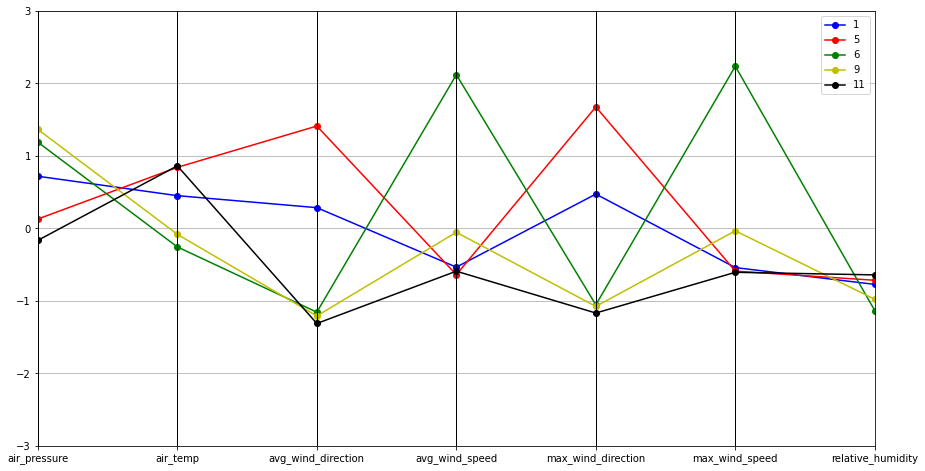

In [27]:
parallel_plot(P[P['relative_humidity'] < -0.5])

### Warm Days

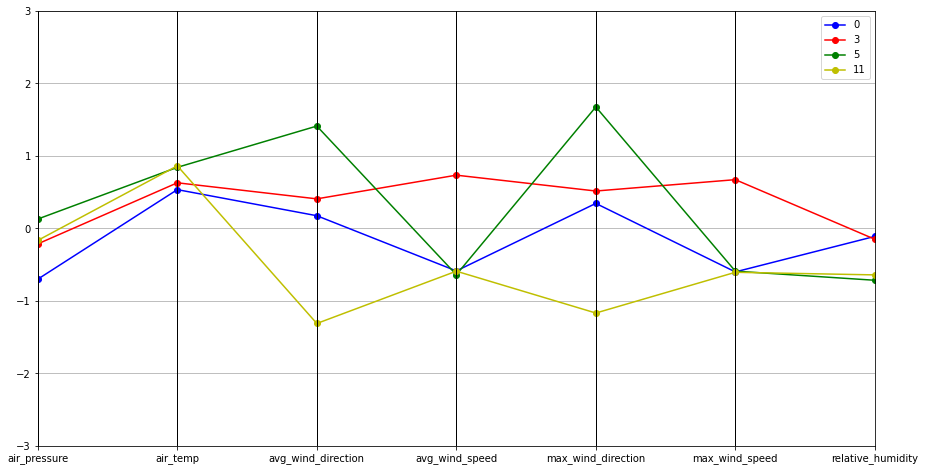

In [28]:
parallel_plot(P[P['air_temp'] > 0.5])

### Cool Days

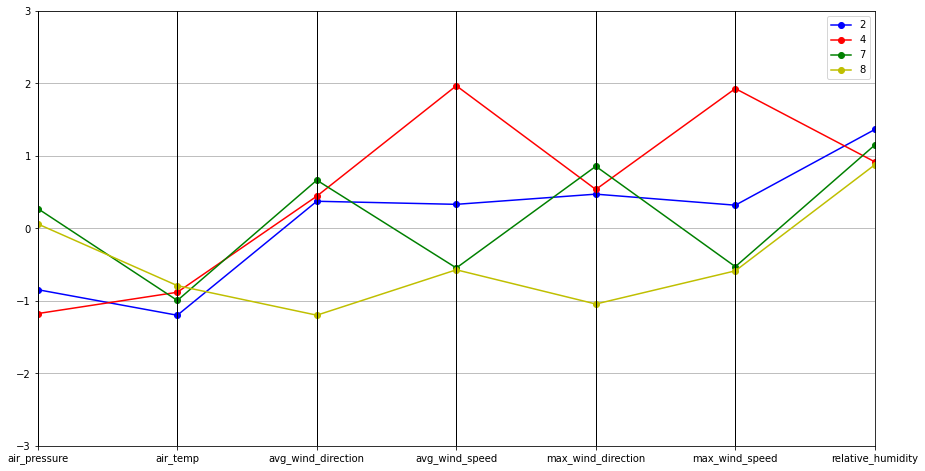

In [29]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])